In [51]:
# data loading and presentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Loading Dataset

In [52]:
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


1
0
1
4
0
0
7
3
5


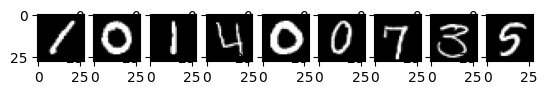

In [54]:
for i in range(9):
    plt.subplot(1, 9, i+1)
    ## we use [i,1:] to denote the row i, from value 1(pixel0) until the end of the row
    plt.imshow(train_df.iloc[i, 1:].values.reshape(28, 28), cmap='gray') 
    print(train_df.iloc[i, 0])

<Axes: ylabel='Frequency'>

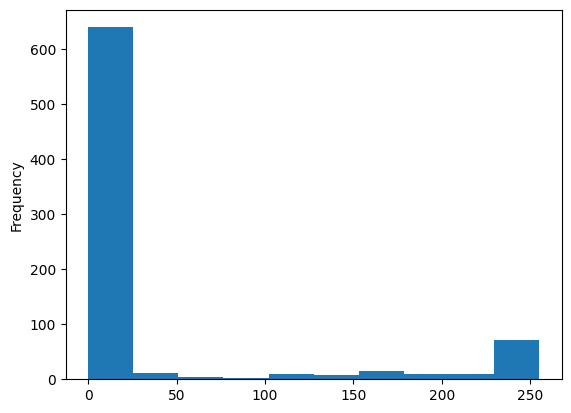

In [55]:
train_df.iloc[i, 1:].plot(kind='hist')

In [82]:
class MNIST_dataset(Dataset):

    def __init__(self, df, rows=42000): # We have 42000 values (letters)
        self.img = df.iloc[:rows, 1:].values # The images are all rows, from value 1 onwards (the pixel values)
        self.labels = df.iloc[:rows, 0].values # The labels are all rows but only on column 0
        self.rows = rows
    
    def __len__(self):
        return self.rows
    
    def __getitem__(self, idx):
        # We normalize the values of each pixel and convert them to tensor
        image = torch.tensor(self.img[idx], dtype=torch.float) / 255  
        # We resize the images to 28x28 like we did before to represent them
        image = image.view(1, 28, 28)  # We resize the images to 28x28 like we did before to represent them
        label = self.labels[idx]
        return (image, label) # When asked to obtain the sample i, it will return the image and its label (0-9)

In [84]:
# We split the training data into a training set and a validation set (90-10%)
train, valid = torch.utils.data.random_split(DataLoader(MNIST_dataset(train_df)).dataset,[0.9,0.1])
print("Training set length:", len(train))
print("Validation set length:",len(valid))

# We load the data using the Dataset model we just made, in batches of 4 and shuffling them. This minibatch size is 
trainloader = DataLoader(train, batch_size = 32, shuffle=True)
validloader = DataLoader(valid, batch_size = 32)

Training set length: 37800
Validation set length: 4200


In [85]:
# This will give us each letter separately to read them one by one
dataiter = iter(trainloader)

In [86]:
# Retrieving the items one by one with next
images, labels = next(dataiter)

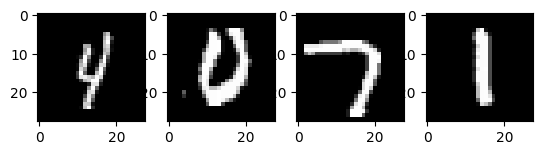

In [91]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i, 0], cmap='gray')

In [88]:
labels

tensor([4, 0, 7, 1, 2, 1, 6, 2, 0, 7, 6, 8, 7, 2, 1, 4, 1, 7, 0, 3, 6, 8, 9, 6,
        9, 4, 4, 1, 7, 3, 4, 0])

## Defining a CNN (Convolutional Neural Network)

![](cnn.png)

It is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:

1. Define the neural network that has some learnable parameters (or weights).

2. Iterate over a dataset of inputs.

3. Process input through the network.

4. Compute the loss (how far is the output from being correct).

5. Propagate gradients back into the network’s parameters.

6. Update the weights of the network, typically using a simple update rule: **weight = weight - learning_rate * gradient**.

In [60]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 4)
        self.conv2 = nn.Conv2d(6, 16, 4)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss Function 

**lr (learning rate)** is a very important hyperparameter. Small lr will make the training process very slow, but a high lr may also cause overshooting the global optimum, causing divergence. A good method to adjust this parameter is plotting the Learning Rate Curve.

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Train the CNN on the Training Data

In [24]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

training_loss_list = []
valid_loss_list = []

for epoch in range(10):
    training_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        training_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, training_loss / 200)
                 )
            training_loss_list.append(training_loss)
            training_loss = 0.0
            
print('Finished Training')

[1,   200] loss: 2.304
[1,   400] loss: 2.293
[1,   600] loss: 2.281
[1,   800] loss: 2.242
[1,  1000] loss: 1.985
[1,  1200] loss: 1.194
[1,  1400] loss: 0.803
[1,  1600] loss: 0.618
[1,  1800] loss: 0.566
[1,  2000] loss: 0.508
[1,  2200] loss: 0.444
[1,  2400] loss: 0.357
[1,  2600] loss: 0.331
[1,  2800] loss: 0.391
[1,  3000] loss: 0.356
[1,  3200] loss: 0.332
[1,  3400] loss: 0.278
[1,  3600] loss: 0.286
[1,  3800] loss: 0.220
[1,  4000] loss: 0.250
[1,  4200] loss: 0.265
[1,  4400] loss: 0.240
[1,  4600] loss: 0.184
[1,  4800] loss: 0.235
[1,  5000] loss: 0.187
[1,  5200] loss: 0.232
[1,  5400] loss: 0.190
[1,  5600] loss: 0.193
[1,  5800] loss: 0.179
[1,  6000] loss: 0.157
[1,  6200] loss: 0.138
[1,  6400] loss: 0.136
[1,  6600] loss: 0.172
[1,  6800] loss: 0.184
[1,  7000] loss: 0.148
[1,  7200] loss: 0.154
[1,  7400] loss: 0.147
[1,  7600] loss: 0.121
[1,  7800] loss: 0.159
[1,  8000] loss: 0.159
[1,  8200] loss: 0.150
[1,  8400] loss: 0.123
[1,  8600] loss: 0.138
[1,  8800] 

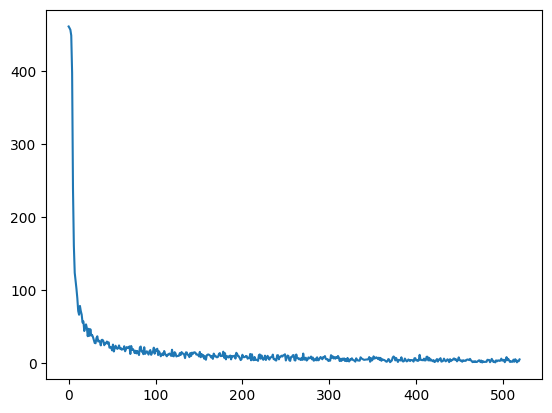

In [25]:
plt.plot(training_loss_list)

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on train images: ', correct/total)

Accuracy of the network on train images:  0.9948571428571429


## Prediction and Submition

In [29]:
test_df = pd.read_csv('test.csv')
test_df.values.shape
test_tensor = torch.tensor(test_df.values, dtype=torch.float) / 255
test_tensor = test_tensor.view(-1, 1, 28, 28)
outputs = net(test_tensor)
_, predicted = torch.max(outputs, 1)
submit_df = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predicted.numpy()})
submit_df.to_csv('cnn.csv', index=False)